In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob

Read all tables for each cell with its time records.

In [2]:
# read all tables from the folder
tables = glob('tables/*.csv')

In [ ]:
# parse each table name to get coords
coords = [table.split('/')[-1].split('(')[1].split(')')[0] for table in tables]

In [4]:
# open each table and create a dataframe
dfs = [pd.read_csv(table) for table in tables]
dfs[0]

,Unnamed: 0,angle,time,angle_change
0,0,145.527786,0,NaN
1,1,141.900328,1,3.627458
2,2,141.340192,2,0.560136
3,3,142.305760,3,0.965568
4,4,142.997473,4,0.691714
...,...,...,...,...
198,198,141.842773,198,0.000000
199,199,142.125016,199,0.282243
200,200,144.904183,200,2.779167
201,201,141.842773,201,3.061410


Create rolling avarage to smooth statistics

In [6]:
# create new column with 7 time units average
for df in dfs:
    df['avg_7'] = df.angle.rolling(7).mean().shift(-3)

,Unnamed: 0,angle,time,angle_change,avg_7
0,0,145.527786,0,NaN,NaN
1,1,141.900328,1,3.627458,NaN
2,2,141.340192,2,0.560136,NaN
3,3,142.305760,3,0.965568,142.116063
4,4,142.997473,4,0.691714,141.517835
...,...,...,...,...,...
198,198,141.842773,198,0.000000,142.278083
199,199,142.125016,199,0.282243,142.360759
200,200,144.904183,200,2.779167,NaN
201,201,141.842773,201,3.061410,NaN


/Users/septentrionalem/python/miniconda3/envs/m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/septentrionalem/python/miniconda3/envs/m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/septentrionalem/python/miniconda3/envs/m1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

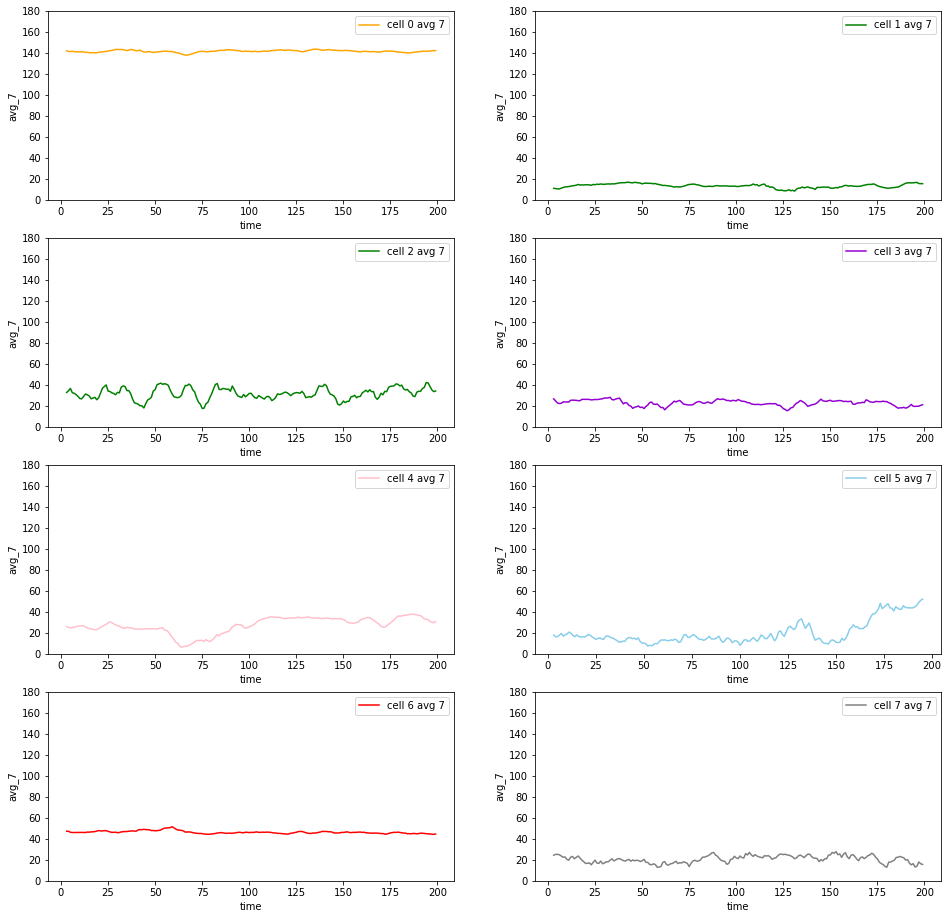

In [7]:
# for each table, create a plot using seaborn ploting the angle column against the time 
# create figure 4 by 4
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

colors = ('orange', 'green', 'green', 'darkviolet', 'pink', 'skyblue', 'red', 'grey')
for i, (df, c) in enumerate(zip(dfs, colors)):
    sns.lineplot(df['time'], df['avg_7'], ax=axes[i//2, i%2], label=f'cell {i} avg 7', color=c)
    # set y axis range
    axes[i//2, i%2].set_ylim(0, 180)
    
fig.show() 

Following code can be used to visualize which cells were measured. 

In [2]:
# import napari and open viewer
import napari
viewer = napari.Viewer()

In [3]:
from utils import *
# open original data
filepath = 'video_sperm/Jeko1_videa/FcRL3_siRNAIII.avi'
image_data = get_image_data(filepath)
viewer.add_image(image_data, name='frames')

<Image layer 'frames' at 0x2a93de1c0>

In [4]:
# add points layers with all coords
points = []
for i, df in enumerate(dfs):
    point = [int((coord.split('.'))[:4][0]) for coord in coords[i].split(',')]
    points.append(point)
    
viewer.add_points(points, name=f'cell points', size=10)

NameError: name 'dfs' is not defined

In [5]:
# visualize masks for selected cells and show vector
from tifffile import imread

# open segmentation
path = 'cells_labels.tiff'
cells = imread(path)
viewer.add_labels(cells, name='cells')

path = 'sperm_labels.tiff'
sperm = imread(path)
viewer.add_labels(sperm, name='sperm')


<Labels layer 'sperm' at 0x2a20a6df0>

In [11]:
import cv2

for i, point in enumerate(points):
    # take cells value from point layer
    cell_id = cells[0][point[0]][point[1]]

    # take only cell with cell_id
    cell = cells.copy()
    cell[cells != cell_id] = 0
    viewer.add_labels(cell, name=f'cell {i}')

In [12]:
# for some cell add vector in first frame
cell = viewer.layers['cell 7'].data
cell = cell[0]

# dilate cell by 3 pixels
cell_dilated = np.zeros_like(cell)
kernel = np.ones((3, 3), np.uint8)
cell_dilated = cv2.dilate(cell.astype(np.uint8), kernel=kernel, iterations=4)

# if any sperm is touching cell dilated, then sperm is interacting with cell

sperm_interacting = np.multiply(sperm, cell_dilated)
sperm_interacting_id = np.unique(sperm_interacting)
sperm_interacting_id = sperm_interacting_id[1:]
print(sperm_interacting_id)

[ 12028  39770 204088 210684]


In [21]:
sperm_coords = np.array(np.where(sperm_interacting == sperm_interacting_id)).T[0]
sperm_cell_value = sperm[0][sperm_coords[0], sperm_coords[1]]

# create sperm cell 
sperm_cell = sperm[0].copy()
sperm_cell[sperm_cell != sperm_cell_value] = 0
viewer.add_labels(sperm_cell, name=f'sperm_cell')

# now do angle measurements for all time frames
cell = cell_dilated

# find stack where the overlap is present
overlap = sperm_interacting.copy()
overlap[overlap != sperm_interacting_id] = 0

overlap_coords = np.array(np.where(overlap != 0))

# compute cell line and cell vector
cell_line, cell_vector = compute_cell_vector(overlap_coords)
sperm_line, sperm_vector = compute_sperm_cell_vector(sperm_cell)


/var/folders/gw/9m0zb5rx7vv69h7z1804vcc00000gn/T/ipykernel_98929/2418761533.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  sperm_coords = np.array(np.where(sperm_interacting == sperm_interacting_id)).T[0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
viewer.add_shapes([cell_line[0], cell_line[1]], name='cell_line', shape_type='line', edge_width=1)
viewer.add_shapes([sperm_line[0], sperm_line[1]], name='sperm_line', shape_type='line', edge_width=1)

<Shapes layer 'sperm_line' at 0x2cdbfd580>

In [2]:
# take all layers from the viewer of cells
layers = viewer.layers
for layer in layers:
    if 'cell ' in layer.name:
        im = layer.data
        # add values to the image
        
        print(im.shape)

NameError: name 'viewer' is not defined

In [2]:
import cv2

cap = cv2.VideoCapture('video.mov')
cap

<VideoCapture 0x111b02fb0>

In [3]:
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# initialize the FourCC and a video writer object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output = cv2.VideoWriter('output.avi', fourcc, fps, (frame_width, frame_height))